# Librairies


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import pyreadr
import xarray

# Préalable

## Initialisation

In [3]:
def initialize(ni,ri):
    Ui = np.zeros((ni, ri))
    indices = np.array_split(np.arange(ni), ri)
    for j, idx in enumerate(indices):
        Ui[idx, j] = 1 / np.sqrt(len(idx))

    return Ui




def initialize_G(r1,r2,r3):
    G= np.random.rand(r1,r2,r3)

    return G

In [4]:
ni=50
ri=20
Ui=np.zeros((50,20))
indices = np.array_split(np.arange(ni), ri)
print(indices[2])


[6 7 8]


## Calcul de l'erreur

In [5]:
def etalT(T):
    n1, n2, n3 = T.shape
    T_prime=np.transpose(T,(0,2,1)).reshape(n1,n3*n2)
    return T_prime

def U23G(U2, U3, G):
    G_=G[:,:,0]*U3[0,0]
    for i in range (1,U3.shape[1]):   
        G_=G_+G[:,:,i]*U3[0,i]
    U23=G_@U2.T

    for j in range (1, U3.shape[0]):
        G_=G[:,:,0]*U3[j,0]
        for i in range (1,U3.shape[1]):   
            G_=G_+G[:,:,i]*U3[j,i]
        U23=np.bmat([[U23 , G_@U2.T]])
    return U23

def calcul_error(T, G, U1, U2, U3):
    Mat=U1 @ U23G(U2, U3, G)
    T_prime=etalT(T)
    error=np.linalg.norm(T_prime-Mat)**2/np.linalg.norm(T_prime)**2
    return error

def calcul_e(T_,U,i,U23g):
    Mat=U @ U23g  
    t=T_[i,:]
    error=np.linalg.norm(t-Mat)**2/np.linalg.norm(t)**2
    return error

def U_normalize(U):
    m,n=U.shape
    for i in range(n):
        norm=np.linalg.norm(U[:,i])
        if norm > 0 :   
            U[:,i]=U[:,i]/norm
    
def snpa(M, r, tol=1e-10, verbose=False):
    """
    SNPA simplifié pour initialiser une NMF séparable.
    M : matrice (m x n) non-négative
    r : nombre de colonnes extrêmes à extraire
    Retourne :
        W : matrice (m x r) formée des colonnes de M choisies
        K : liste des indices de colonnes choisies
    """
    M = np.asarray(M, dtype=float)
    m, n = M.shape

    R = M.copy()
    K = []

    for k in range(r):
        # 1) Choix de la colonne la plus "éloignée"
        col_norms = np.sum(R * R, axis=0)
        j = np.argmax(col_norms)
        max_norm = col_norms[j]

        if verbose:
            print(f"[SNPA] step {k+1}, max residual norm = {max_norm:.3e}")

        # Si le résidu est quasi nul, on arrête
        if max_norm < tol:
            if verbose:
                print("[SNPA] Residual too small → stop early.")
            break

        K.append(int(j))

        # 2) Projection non-négative sur le cône généré par M[:, K]
        A = M[:, K]                       # (m x k)
        AtA = A.T @ A                     # (k x k)
        # petite régularisation pour éviter les problèmes numériques
        AtA_reg = AtA + 1e-12 * np.eye(AtA.shape[0])
        AtM = A.T @ M                     # (k x n)

        # Résolution en bloc du LS : AtA * H = AtM
        H = np.linalg.solve(AtA_reg, AtM) # (k x n)
        # projection non-négative
        H = np.maximum(H, 0.0)

        # Optionnel : projeter sur le simplexe (somme <= 1)
        col_sums = np.sum(H, axis=0, keepdims=True)
        col_sums = np.maximum(col_sums, 1.0)
        H /= col_sums

        # 3) Mise à jour du résidu
        R = M - A @ H

    # Construction de W = M[:,K]
    if len(K) < r:
        # si on s'est arrêté avant r, on complète arbitrairement
        # (pratique quand r est grand et/ou donnée bruitée)
        remaining = [j for j in range(n) if j not in K]
        K += remaining[:(r - len(K))]

    W = M[:, K]  # (m x r)

    # Normalisation des colonnes pour être compatible avec ton U_normalize
    for j in range(W.shape[1]):
        norm = np.linalg.norm(W[:, j])
        if norm > 0:
            W[:, j] /= norm

    return W, K

def init_U_snpa_from_mode(T, mode, r, verbose=False):
    """
    Initialise U_mode avec SNPA en appliquant SNPA sur l'unfolding
    correspondant au mode donné.
    
    mode : 0, 1 ou 2  (pour les modes 1, 2, 3)
    r    : rang pour ce mode
    """
    if mode == 0:
        Tm = T
    elif mode == 1:
        Tm = np.transpose(T, (1, 0, 2))
    elif mode == 2:
        Tm = np.transpose(T, (2, 0, 1))
    else:
        raise ValueError("mode doit être 0, 1 ou 2")

    # Unfolding comme dans etalT : (n_mode, n_other * n_other)
    M = etalT(Tm)   # n_mode x (n_other1 * n_other2)

    if verbose:
        print(f"[init_U_snpa_from_mode] M.shape = {M.shape}")

    U, K = snpa(M, r, verbose=verbose)

    # Pour être cohérent avec tes autres fonctions
    U_normalize(U)

    if verbose:
        print(f"[init_U_snpa_from_mode] {len(K)} colonnes extrêmes sélectionnées.")

    return U

## Optimisation

In [6]:
def mode_n_product(X, M, mode):
    Xm = np.moveaxis(X, mode, 0)            
    Y = np.tensordot(M, Xm, axes=(1,0))      
    return np.moveaxis(Y, 0, mode) 

def optiG(T,U1,U2,U3,G,rcond=None):

    U_normalize(U1)
    U_normalize(U2)
    U_normalize(U3)
    
    pinv1 = U1.T
    pinv2 = U2.T
    pinv3 = U3.T
    G = mode_n_product(T, pinv1, mode=0)
    G = mode_n_product(G, pinv2, mode=1)
    G = mode_n_product(G, pinv3, mode=2)
    return G

In [7]:
def optiU(T, U, U2, U3, G):
    T_ = etalT(T)
    n1 = T.shape[0]
    r1 = G.shape[0]

    U_save = U.copy()
    value_save = calcul_error(T, G, U_save, U2, U3)

    U23g = U23G(U2, U3, G)  
    eps = 1e-12  

    for i in range(n1):

        best_j = 0
        best_err = float('inf')
        best_val = 0
        #Uiprev = U[i, :].copy()
        #err0 = calcul_e(T_, Uiprev, i, U23g)
        #print(f"i: {i}, err0: {err0}")
        for j in range(r1):

            #U_tmp = U[i,:].copy()
            #U_tmp[:] = 0
            Ulignei = np.zeros(r1)

            denom = np.linalg.norm(U23g[j, :])**2 + eps
            Ulignei[j] = (T_[i, :] @ U23g[j, :].T) / denom

            #U_test = U.copy()
            #U_test[i, :] = U_tmp

            err = calcul_e(T_, Ulignei, i, U23g)
            #print(f"i: {i}, j: {j}, err: {err}, best_err: {best_err}")
            if err < best_err:
                best_err = err
                best_val = Ulignei[j]
                best_j = j

        U[i, :] = 0
        #denom = np.linalg.norm(U23g[best_j, :])**2 + eps
        U[i, best_j] = best_val #(T_[i, :] @ U23g[best_j, :].T) / denom
        #Uiprev = U[i, :].copy()
        #err0 = calcul_e(T_, Uiprev, i, U23g)
        #print(f"i: {i}, err1: {err0}")

    err= calcul_error(T, G, U, U2, U3)
    return U, err

In [8]:
def Optimization(T, U1, U2, U3, G, max_iter=10,maxtime=300,tol=1e-6):
    erreurU1=[]
    erreurU2=[]
    erreurU3=[]
    start_time=time.time()

    for i in range (max_iter):
        print(f"__________itération {i+1} __________")

        T1 = T  
        #print(f"erreur avant : {calcul_error (T1,G,U1,U2,U3)}")
        U1,err = optiU(T1, U1, U2, U3, G)
        erreurU1.append(err)
        #print(f"Erreur après : {err}")

        T2 = np.transpose(T, (1, 0, 2))  
        #print(f"erreur avant : {calcul_error(T2,np.transpose(G, (1, 0, 2)),U2,U1,U3)}")
        U2,err = optiU(T2, U2, U1, U3, np.transpose(G, (1, 0, 2)))
        erreurU2.append(err)
        #print(f"Erreur U2 : {err}")

      
        T3 = np.transpose(T, (2, 0, 1))  
        #print(f"erreur avant : {calcul_error (T3,np.transpose(G, (2, 0, 1)),U3,U1,U2)}")
        U3,err = optiU(T3, U3, U1, U2, np.transpose(G, (2, 0, 1)))
        erreurU3.append(err)
        #print(f"Erreur U3 : {err}")
        print("Erreurs : ",erreurU1[-1], erreurU2[-1], erreurU3[-1])

        G=optiG(T,U1,U2,U3,G)

        error=calcul_error (T,G,U1,U2,U3)
        if erreurU1[-1]<tol or erreurU2[-1]<tol or erreurU3[-1]<tol:
            print("Seuil de tolérance atteint")
            break
        if time.time()-start_time>maxtime:
            print("Temps maximum écoulé")
            break
        
    return U1,U2,U3,G,erreurU1,erreurU2,erreurU3

## Print

In [9]:
def print_results(erreurU1,erreurU2,erreurU3):
    plt.plot(erreurU1, label='Erreur U1',color='red')
    plt.plot(erreurU2, label='Erreur U2',color='blue')
    plt.plot(erreurU3, label='Erreur U3',color='k')
    plt.yscale('log')
    plt.xlabel('Itérations')
    plt.ylabel('Erreur')
    plt.title('Convergence des erreurs')
    plt.legend()
    plt.show()

# Algo

Variables

In [10]:
#Jeu de données US airport

T_flat = np.load("airport_tensor.npy")   # shape = (8117781,)
print(T_flat.shape)

# R a "aplatit" en ordre colonne → on remet en forme avec order="F"
T = T_flat.reshape((343, 343, 69), order="F")

print(T.shape)              # doit afficher (343, 343, 69)
print(T[:10, :10, 0])       # les 10x10 premiers de la 1ère matrice

(8117781,)
(343, 343, 69)
[[  0. 273. 138.   0. 126.   0.   0.   0.  31. 132.]
 [276.   0. 462. 255. 459. 255. 303.  87. 262. 182.]
 [134. 462.   0.  79. 292.  71. 169.  21. 183.  87.]
 [  0. 256.  74.   0. 318.   0.   1.   0.  55. 129.]
 [130. 464. 293. 302.   0. 130. 110.   0. 125.   0.]
 [  0. 256.  70.   0. 131.   0.   1.   0.   0.   0.]
 [  0. 303. 169.   1. 101.   0.   0.   0.  51. 102.]
 [  0.  87.  22.   0.   0.   0.   0.   0.   0.   0.]
 [ 31. 262. 181.  56. 128.   0.  56.   0.   0.  27.]
 [133. 184.  86. 128.   0.   0. 101.   0.  26.   0.]]


In [11]:
max_iter=10
tol=1e-6
maxtime=500

In [12]:
np.random.seed(42)
#T=T[:5, :6, :3]
n1,n2,n3=T.shape
r1=100
r2=100
r3=60
U1 = init_U_snpa_from_mode(T, mode=0, r=r1, verbose=True)
U2 = init_U_snpa_from_mode(T, mode=1, r=r2, verbose=True)
U3 = init_U_snpa_from_mode(T, mode=2, r=r3, verbose=True)
G=initialize_G(r1,r2,r3)

[init_U_snpa_from_mode] M.shape = (343, 23667)
[SNPA] step 1, max residual norm = 1.430e+07
[SNPA] step 2, max residual norm = 9.649e+06
[SNPA] step 3, max residual norm = 5.504e+06
[SNPA] step 4, max residual norm = 5.081e+06
[SNPA] step 5, max residual norm = 3.559e+06
[SNPA] step 6, max residual norm = 2.645e+06
[SNPA] step 7, max residual norm = 2.478e+06
[SNPA] step 8, max residual norm = 2.169e+06
[SNPA] step 9, max residual norm = 1.781e+06
[SNPA] step 10, max residual norm = 1.746e+06
[SNPA] step 11, max residual norm = 1.352e+06
[SNPA] step 12, max residual norm = 1.465e+06
[SNPA] step 13, max residual norm = 1.560e+06
[SNPA] step 14, max residual norm = 1.963e+06
[SNPA] step 15, max residual norm = 1.442e+06
[SNPA] step 16, max residual norm = 1.326e+06
[SNPA] step 17, max residual norm = 1.241e+06
[SNPA] step 18, max residual norm = 2.153e+06
[SNPA] step 19, max residual norm = 1.509e+06
[SNPA] step 20, max residual norm = 2.705e+06
[SNPA] step 21, max residual norm = 1.910e

__________itération 1 __________


C:\Users\julie\AppData\Local\Temp\ipykernel_7504\261254285.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ulignei[j] = (T_[i, :] @ U23g[j, :].T) / denom


Erreurs :  0.43454778232620456 0.3804439474239139 0.44483300740924514
__________itération 2 __________
Erreurs :  0.2226311192686714 0.20962069065283173 0.20889661495753536
__________itération 3 __________
Erreurs :  0.1947752115890484 0.19280114141865035 0.19260725186187952
__________itération 4 __________
Erreurs :  0.18659380867252076 0.18614903712285893 0.18575990431119194
__________itération 5 __________
Erreurs :  0.18288409619142304 0.182512305718663 0.18232056215698733
__________itération 6 __________
Erreurs :  0.1767611068864336 0.17461371639430734 0.17461334044483423
__________itération 7 __________
Erreurs :  0.17319839052360417 0.17311837033276053 0.17311833981047012
__________itération 8 __________
Erreurs :  0.17281711345453363 0.17274845208018397 0.17274843459813055
Temps maximum écoulé


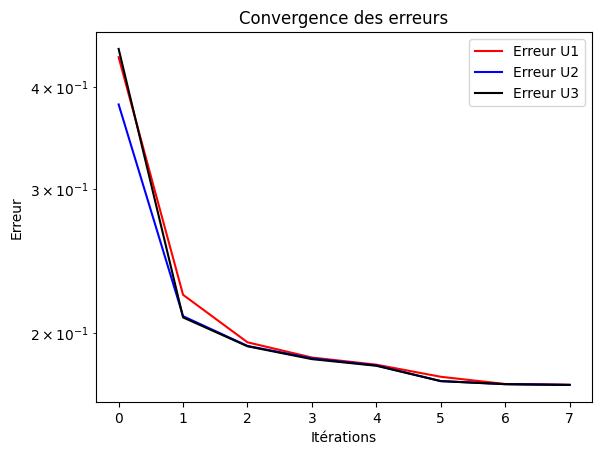

In [13]:
U1,U2,U3,G,erreurU1,erreurU2,erreurU3=Optimization(T, U1, U2, U3, G, max_iter,maxtime,tol)
print_results(erreurU1,erreurU2,erreurU3)